In [30]:
# Params
BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 1.0
OPTIM_GAMMA = 0.7
# Define NN
import torch
import torch.nn as nn
import torch.nn.functional as f



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28224, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = f.relu(x)
        x = self.conv2(x)
        x = f.relu(x)
        x = f.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = f.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        out = f.log_softmax(x, dim=1)
        return out



In [31]:
# Load the Data
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.ImageFolder(root = 'train', transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                                         transforms.ToTensor()]))
test_dataset = datasets.ImageFolder(root = 'validation', transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                                         transforms.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



Feature batch shape: torch.Size([256, 1, 48, 48])
Labels batch shape: torch.Size([256])


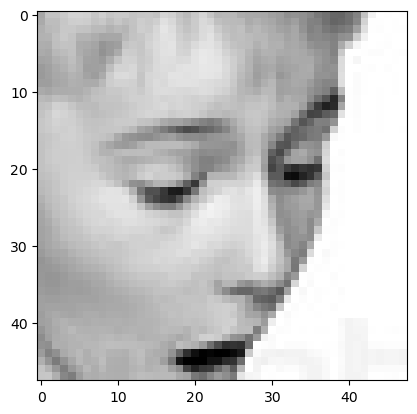

Label: 6


In [32]:
# Display image and label.
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [33]:
# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

In [34]:
# Test Feeding Model
train_features, train_labels = next(iter(train_loader))
train_features.to(device)
output = model(train_features)
print(f"Output = {output}")
print(f"Expected = {train_labels}")

Output = tensor([[-2.3675, -2.3168, -2.2847,  ..., -2.3451, -2.2340, -2.3584],
        [-2.3847, -2.3078, -2.3148,  ..., -2.4064, -2.2762, -2.3363],
        [-2.3749, -2.1550, -2.3996,  ..., -2.3504, -2.2392, -2.3609],
        ...,
        [-2.3788, -2.2507, -2.3188,  ..., -2.3748, -2.2530, -2.3426],
        [-2.4576, -2.2304, -2.2879,  ..., -2.4111, -2.1838, -2.4199],
        [-2.4214, -2.2347, -2.2753,  ..., -2.3693, -2.3317, -2.2956]],
       grad_fn=<LogSoftmaxBackward0>)
Expected = tensor([5, 3, 4, 4, 0, 3, 3, 2, 4, 6, 4, 3, 4, 6, 6, 0, 0, 3, 5, 0, 6, 5, 3, 0,
        0, 3, 2, 0, 4, 4, 2, 3, 3, 2, 2, 0, 2, 0, 3, 4, 1, 0, 3, 4, 3, 5, 3, 6,
        5, 0, 6, 0, 1, 0, 3, 4, 5, 3, 3, 5, 5, 3, 0, 5, 5, 4, 4, 2, 4, 2, 5, 4,
        3, 4, 6, 4, 5, 0, 3, 1, 2, 2, 4, 0, 0, 3, 2, 2, 0, 1, 5, 3, 2, 2, 6, 3,
        3, 3, 0, 3, 5, 5, 2, 3, 4, 0, 4, 0, 6, 5, 3, 2, 5, 3, 4, 4, 3, 4, 5, 0,
        5, 3, 3, 5, 3, 4, 2, 4, 2, 0, 2, 4, 4, 4, 3, 6, 6, 6, 0, 6, 6, 6, 4, 5,
        3, 3, 2, 4, 5, 0, 0,

In [35]:
# Train Model
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def train(model, train_loader, optimizer, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=1, gamma=OPTIM_GAMMA)

for i in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, device)
    test(model, test_loader, device)
    scheduler.step()





Test set: Average loss: 1.7843, Accuracy: 1858/7066 (26%)


KeyboardInterrupt: 